# 04 - Model Building

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error

In [2]:
train_full = pd.read_csv('../data/processed/train.csv')
train_full.head()

,dTime,dTimeUTC,aTime,aTimeUTC,airlines,fly_duration,flyFrom,cityFrom,cityCodeFrom,flyTo,...,session,orig-dest,airline,days_until_dep,hops,direct,competition,id,hist_prices,waiting_days
0,15:00,2021-02-01 14:00:00,16:25,2021-02-01 15:25:00,UX,1.416667,MAD,Madrid,MAD,BCN,...,afternoon,MAD-BCN,UX,1,0,True,6,134,[78],0
1,09:35,2021-02-01 08:35:00,10:50,2021-02-01 09:50:00,VY,1.250000,MAD,Madrid,MAD,BCN,...,morning,MAD-BCN,VY,1,0,True,6,124,[91],0
2,19:45,2021-02-01 18:45:00,21:05,2021-02-01 20:05:00,IB,1.333333,MAD,Madrid,MAD,BCN,...,evening,MAD-BCN,IB,1,0,True,6,139,[91],0
3,19:15,2021-02-01 18:15:00,08:50,2021-02-02 07:50:00,UX,13.583333,MAD,Madrid,MAD,BCN,...,evening,MAD-BCN,UX,1,0,True,6,137,[108],0
4,14:50,2021-02-01 13:50:00,08:50,2021-02-02 07:50:00,UX,18.000000,MAD,Madrid,MAD,BCN,...,afternoon,MAD-BCN,UX,1,0,True,6,132,[112],0


### Feature selection and Preprocessing

### Split train and validation

In [5]:
def split_data(df, test_days=14):
    flight_dates = pd.to_datetime(df['dDate'])
    split_date = flight_dates.max() - timedelta(days=test_days)
    train = df[flight_dates <= split_date].copy()
    test = df[flight_dates > split_date].copy()
    return train, test

In [ ]:
train, valid = split_data(train_full)
train.shape, valid.shape

In [5]:
train_prices = train[['price', 'hist_prices']].copy()
valid_prices = valid[['price','days_until_dep', 'hist_prices']].copy()

In [7]:
num_attribs = ['days_until_dep', 'fly_duration', 'day_of_month', 'log_price', 'hops', 'competition']
cat_attribs = ['flyFrom', 'flyTo', 'day_of_week', 'session']
target = 'waiting_days'

In [8]:
train = train[num_attribs+cat_attribs+[target]]
valid = valid[num_attribs+cat_attribs+[target]]

In [9]:
# split features and target
X_train = train.drop(target, axis=1).copy()
y_train = train[target].copy()

X_valid = valid.drop(target, axis=1).copy()
y_valid = valid[target].copy()

In [10]:
X_train.head()

,days_until_dep,fly_duration,day_of_month,log_price,hops,competition,flyFrom,flyTo,day_of_week,session
0,1,1.416667,1,4.356709,0,6,MAD,BCN,Monday,morning
1,1,1.250000,1,4.510860,0,6,MAD,BCN,Monday,morning
2,1,1.333333,1,4.510860,0,6,MAD,BCN,Monday,evening
3,1,13.583333,1,4.682131,0,6,MAD,BCN,Monday,evening
4,1,18.000000,1,4.718499,0,6,MAD,BCN,Monday,morning


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [12]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_valid_prepared = full_pipeline.transform(X_valid)

In [13]:
X_train_prepared.shape, y_train.shape,  X_valid_prepared.shape, y_valid.shape

((49070, 28), (49070,), (7630, 28), (7630,))

### Model building

In [14]:
def train_model(model, X_train, y_train, X_valid, y_valid, refit=True):
    if refit:
        model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    training_err = np.sqrt(mean_squared_error(y_train, y_pred_train))
    valid_err = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    print('training:', training_err)
    print('validation:', valid_err)
    return model

In [15]:
%%time
lr = LinearRegression()
train_model(lr, X_train_prepared, y_train, X_valid_prepared, y_valid)

training: 2.771721969855917
validation: 4.81338426945493
CPU times: user 169 ms, sys: 139 ms, total: 308 ms
Wall time: 93.4 ms


LinearRegression()

In [16]:
%%time
rf = RandomForestRegressor()
train_model(rf, X_train_prepared, y_train, X_valid_prepared, y_valid)

training: 0.42347342629900153
validation: 4.567145448849963
CPU times: user 17.3 s, sys: 615 ms, total: 17.9 s
Wall time: 17.4 s


RandomForestRegressor()

In [17]:
predicted = rf.predict(X_valid_prepared).round()

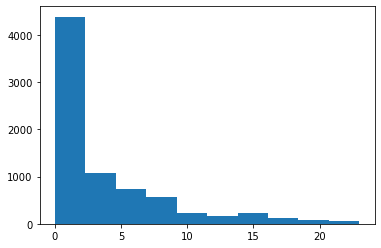

In [18]:
import matplotlib.pyplot as plt
plt.hist(predicted);

In [19]:
test = pd.read_csv('../data/processed/test_processed.csv')

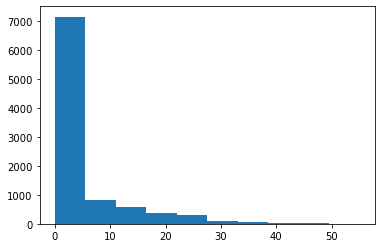

In [20]:
plt.hist(test['waiting_days']);

In [21]:
np.ceil(1.9)

2.0

In [26]:
valid_prices['waiting_days'] = np.round(predicted).astype(int)

In [27]:
valid_prices

,price,days_until_dep,hist_prices,waiting_days
7231,34,41,"[34, 34, 61, 61, 61, 61, 61, 61, 47, 47, 47, 4...",0
7232,34,40,"[34, 34, 61, 61, 61, 61, 61, 61, 47, 47, 47, 4...",0
7233,61,39,"[34, 34, 61, 61, 61, 61, 61, 61, 47, 47, 47, 4...",6
7234,61,38,"[34, 34, 61, 61, 61, 61, 61, 61, 47, 47, 47, 4...",6
7235,61,37,"[34, 34, 61, 61, 61, 61, 61, 61, 47, 47, 47, 4...",7
...,...,...,...,...
56695,262,2,"[262, 209]",0
56696,314,1,[314],0
56697,323,1,[323],0
56698,346,1,[346],0


In [54]:
def f(row):
    if row['waiting_days'] != 0:
        #idx = row['waiting_days'] - 1
        
        list_prices = row['hist_prices'].strip('][').split(', ')
        idx = len(list_prices)-row['days_until_dep']+row['waiting_days']
        
        waiting_price = float(list_prices[idx])
    else:
        waiting_price = row['price']
        
    return waiting_price

In [55]:
valid_prices['waiting_price'] = valid_prices.apply(f, axis=1)

In [56]:
valid_prices['savings'] = valid_prices['price'] - valid_prices['waiting_price']

In [57]:
valid_prices['waiting_price'].fillna(valid_prices[valid_prices['waiting_price'].isna()]['price'], inplace=True)

In [58]:
valid_prices['waiting_price'].isna().sum()

0

In [59]:
print('Spent without waiting: ', valid_prices['price'].sum())
print('Spent with waiting: ', valid_prices['waiting_price'].sum())
print('Save Money:', valid_prices['price'].sum()-valid_prices['waiting_price'].sum())
percent = round(valid_prices['savings'].sum()/valid_prices['price'].sum()*100, 2)
print(str(percent)+'%')

Spent without waiting:  2147360
Spent with waiting:  2179968.0
Save Money: -32608.0
-1.52%


## Save model

In [60]:
import pickle


pickle.dump(rf, open('../models/random_forest.pkl', 'wb'))
pickle.dump(full_pipeline, open('../models/pipeline.pkl', 'wb'))

### Learning curve

In [ ]:
def plot_learning_curve(model, X, y, cv=5, scoring='f1'):
    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, cv=cv, scoring=scoring)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error');
    plt.legend()